# Superdense Coding

If one wants to transmit classically two bits of information they need two bits for this. In quantum communication one can send to bits of information with only qubit by utilizing pre-shared entanglement of two qubits. This quantum communication protocol is known as superdense coding and it was introduced in 1992 by Bennett and Wiesner.[1] Here, the word "dense" refers to the fact that one can encode more than one bit of information to a single qubit. This doesn't violate Holevo bound which sets an upper limit for how much information one qubit can hold because of the pre-shared entanglement of the two qubits. [2,3].

Quantum communication is a widely researched field, since utilizing entanglement in communication protocols can improve the security of information transfer. Because superdense coding is a protocol that utilizes entanglement and it can carried out experimentally this makes it an important protocol to study in practice to improve error mitigation. [5]

The process of superdense coding requires several steps. First, one party, which I will refer to as "Bob", prepares a maximally entangled Bell state and sends one of the two qubits to another party, which I will refer to as "Alice". Alice can apply one of the four quantum operations on her qubit to encode the message. The operations are identity, bit flip, phase flip or product of phase flip and bit flip. After this she sends the qubit back to Bob and he can decode the message by measuring both qubits in bell basis. This measurement will result in a string of two classical bits which is the message Alice sent. [3]

The objective of this project is to implement a superdense coding circuit in Qiskit and experiment with it. In the first section I will apply superdense coding protocol using two qubits. In the second section I will show how an eavesdropper can intercept the message. In the third section I will generalize the superdense coding to three qubits.

AI was used in this project to find incorrect statements and unclear sentences which I corrected by myself if necessary [6].

## Superdense coding with Bell state

In this section I apply superdense coding using Bell state as my initial state. For each message it will be tested that Bob receives the correct message.

In [1]:
#Imported libraries that will be used in this project
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator, QasmSimulator
import pandas as pd
import numpy as np
from IPython.display import Image, display

In [2]:
def superdense_quantumcircuit(bit_message, eavesdropper):
    """
    Function creates a quantum circuit to test the superdense coding protocol.
    Additionally, eavesdropper can be added to intercept the message.
    parameters:
        bit_message: String
            two bit message that Alice sends to Bob
        eavesdropper: Boolean
            If true adds eavesdropper to the circuit
    returns:
        Quantum circuit of the protocol
    """
    # Quantum circuit with two qubits, q_0 is Alice's qubit and q_1 is Bob's qubit.
    q = QuantumRegister(2)
    if (eavesdropper):
        c = ClassicalRegister(3)
    else:
        c = ClassicalRegister(2)
    circ = QuantumCircuit(q,c)
    
    # Prepare Bell state by first operating with Hadamard gate on q_0 and then
    # performing CNOT where q_0 is control and q_1 is target.
    circ.h(q[0])
    circ.cx(q[0], q[1])
    
    # barrier for visual separation 
    circ.barrier()
    
    #Alice's encoding
    #Applied gates depend on the message and they only operate on the Alice's qubit
    if bit_message == "00":
        #Identity operator
        circ.id(q[0])
    if bit_message == "10":
        #Bit flip
        circ.x(q[0])
    if bit_message == "01":
        #Phase flip
        circ.z(q[0])
    if bit_message == "11":
        #Phase flip
        circ.z(q[0])
        #Bit flip
        circ.x(q[0])

    circ.barrier()
    
    # Eavesdropper intercepts the message
    #Measures the first qubit and sends a new one which depends on the measurement
    if (eavesdropper):
        circ.measure(q[0],c[2])
        circ.reset(q[0])
        with circ.if_test((c[2], 0)):
            circ.x(q[0])

        circ.barrier()
        
    #Bob Decodes the message
    # Apply gates in the reverse order of Bell state preparation
    circ.cx(q[0], q[1])
    circ.h(q[0])
    
    #Measure the qubits
    circ.measure(q[0],c[0])
    circ.measure(q[1],c[1])
    
    return circ

In [3]:
#All the possible messages
messages = ["00","01","10","11"]

# Expected message, first resulted message and the proportion of the first outcome
# to all the outcomes will be appended to dataframe. 
messages_df = pd.DataFrame(columns = ["Expected", "Result", "Proportion"])

#Simulation is executed 1000 times for each message
simulator = AerSimulator()
shots = 1000
for message in messages:
    circ = superdense_quantumcircuit(bit_message=message, eavesdropper=False)
    compiled_circuit = transpile(circ, simulator)
    sim_result = simulator.run(compiled_circuit, shots=shots).result()
    counts = sim_result.get_counts()
    key = list(counts.keys())[0]
    values = list(counts.values())[0]
    messages_df.loc[len(messages_df)] = {"Expected": message, "Result": key, "Proportion": values/shots}

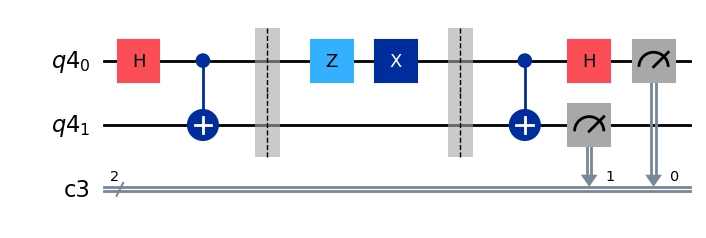

In [4]:
#Visualizes the quantum circuit for bit message "11"
circ.draw("mpl")

Here is a visualization of the superdense coding protocol using two qubits. First, Bell state is prepared. Then the entangled state is transformed to one of the Bell states depending on the message. Finally, gates are applied in reverse order of bell state preparation to get a state in the following basis {00,01,10,11} which is the message Alice transmitted.

In [5]:
display(messages_df)

,Expected,Result,Proportion
0,00,00,1.0
1,01,01,1.0
2,10,10,1.0
3,11,11,1.0


The table shows that there is no uncertainty in the measured outcomes and the messages Bob received are always the ones Alice intended to transmit.

## Security of superdense coding

In this section I will add an eavesdropper "Eve" to the previous superdense coding setup. The measurements are done for one message to see how this will change the measurement outcomes for Bob. In addition, Eve will measure Alice's qubit and send a new one to Bob. The new qubit is always orthogonal to the one Eve measured.

In [6]:
#Simulation is executed 1000 times for a message 01.
circ_eve = superdense_quantumcircuit(bit_message = "01", eavesdropper = True)
compiled_circuit = transpile(circ_eve, simulator)
sim_result = simulator.run(compiled_circuit, shots=shots).result()
counts_eve = sim_result.get_counts()

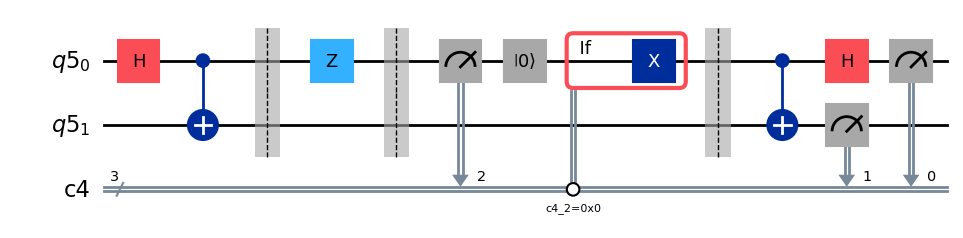

In [7]:
circ_eve.draw("mpl")

Here is a visualization of the setup where an eavesdropper intercepts the message Alice encoded. First, Bell state is prepared, then Alice transforms the state. After this, Eve measures Alice's qubit which is the only qubit she can measure and sends a new one to Bob which is orthogonal to the measured qubit. Finally, Bob, assuming the qubits are still entangled, measures them in Bell basis.

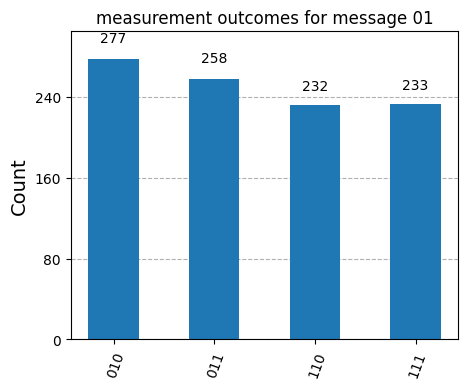

In [8]:
plot_histogram(counts_eve,figsize=(5,4), title="measurement outcomes for message 01")

The histogram shows the measured outcomes of Bob and Eve when the indeded message by Alice was 01. In the x-axis the first digit in a three digit string is the measurement of Eve and the latter two digits are the measurements of Bob. From the results we can see that for Eve the measurement outcome is random. The consequence of Eve measuring Alice's qubit is that the two qubits disentangle. By sending an orthogonal qubit to the one Eve measured to Bob he can measure two different states and neither one is Alice's message.

## Superdense coding using a GHZ state

In this section I will generalize superdense coding to three qubits by preparing Greenberg-Horne-Zeilinger (GHZ) state as the initial state. It is not possible to generate all eight orthogonal states from GHZ state by only transforming one qubit [4]. Therefore, Alice has to operate on two of the entangled qubits.

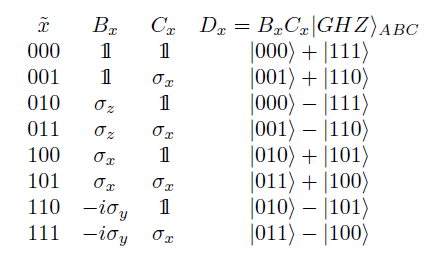

In [9]:
display(Image(filename='messages_for_three_bit_message.PNG', width="300", height="300"))

    Each operation is assigned with a label in the message encoding. All the states are distinguishable and obtained from the initial GHZ state. In this figure Alice’s qubits are in states B and C, and Bob’s qubit is in state A. [2]

When Generalizing the superdense coding to three qubits the idea is similar to two qubits. First, GHZ state is prepared as the inital state, then Alice operates on two of the qubits and sends them to Bob. Finally, Bob will measure the state in GHZ basis by applying the gates in reverse order of GHZ state preparation.

In [10]:
def superdense_ghz(bit_message):
    """
    Function creates a quantum circuit to test superdense coding protocol
    using three qubits.
    parameters:
        bit_message: String
            three bit message that Alice sends to Bob
    returns:
        Quantum circuit of the protocol
    """
    
    # Quantum circuit with three qubits, q_0 and q_1 are Alice's qubit
    # and q_2 is Bob's qubit.
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    circ = QuantumCircuit(q,c)
    # prepare GHZ state 
    circ.h(q[0])
    circ.cx(q[0], q[1])
    circ.cx(q[0], q[2])
    
    # barrier for visual separation 
    circ.barrier()
    
    #Alice's encoding
    #The gates are applied based on the above table
    if bit_message == "000":
        circ.id(q[1])
        circ.id(q[0])
    if bit_message == "001":
        circ.id(q[1])
        circ.x(q[0])
    if bit_message == "010":
        circ.z(q[1])
        circ.id(q[0])
    if bit_message == "011":
        circ.z(q[1])
        circ.x(q[0])
    if bit_message == "100":
        circ.x(q[1])
        circ.id(q[0])
    if bit_message == "101":
        circ.x(q[1])
        circ.x(q[0])
    if bit_message == "110":
        circ.z(q[1])
        circ.x(q[1])
        circ.id(q[0])
    if bit_message == "111":
        circ.z(q[1])
        circ.x(q[1])
        circ.x(q[0])

    circ.barrier()
    
    #Bob decodes the message
    circ.cx(q[0], q[2])
    circ.cx(q[0], q[1])
    circ.h(q[0])
    
    circ.measure(q[0], c[0])
    circ.measure(q[1], c[1])
    circ.measure(q[2], c[2])
    
    return circ

In [11]:
# Superdense coding will be tested for every message
messages = ["000", "001", "010", "011","100", "101", "110", "111"]
simulator = AerSimulator()

messages_ghz_df = pd.DataFrame(columns = ["Expected", "Result", "Proportion"])

#Simulation is executed 1000 times for each message
for message in messages:
    circ_ghz = superdense_ghz(bit_message=message)
    compiled_circuit = transpile(circ_ghz, simulator)
    sim_result = simulator.run(compiled_circuit, shots=shots).result()
    counts = sim_result.get_counts()
    key = list(counts.keys())[0]
    values = list(counts.values())[0]
    messages_ghz_df.loc[len(messages_ghz_df)] = {"Expected": message, "Result": key, "Proportion": values/shots}
    

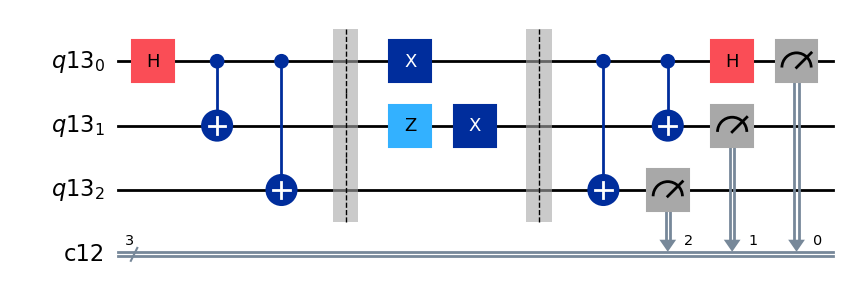

In [12]:
#Visualization of quantum circuit for message 111
circ_ghz.draw("mpl")

Here is a visualization of the setup where the initial state is GHZ state and Alice operates on circuits q0 and q1. Bob measures the state by applying gates in reverse order of GHZ state preparation.

In [13]:
display(messages_ghz_df)

,Expected,Result,Proportion
0,000,000,1.0
1,001,110,1.0
2,010,001,1.0
3,011,111,1.0
4,100,010,1.0
5,101,100,1.0
6,110,011,1.0
7,111,101,1.0


From this table we can see that for every message, excluding 000, there is a mismatch between the intended message and the one Bob received. However, for every encoded message Bob measured a single unique state. Therefore, this is a valid result and only Alice's encoding labels are assigned incorrectly.

## Conclusions

Quantum communication is a widely researched field, since entanglement can improve the security of information transfer. Because superdense coding is a protocol that utilizes entanglement and it can carried out experimentally this makes it an important protocol to study in practice to improve error mitigation. 

In this project I implemented a superdense coding circuit in Qiskit to test the protocol for Bell state and GHZ state. As I have shown the protocol can be generalized to three qubits. It needs to be noted that for GHZ state the protocol achieved 3/2 bits per qubit whereas for Bell state the protocol achieved 2 bits per qubit. This means that the qubits are more dense in two qubit superdense coding. In this project I didn't investigate how different qubit densities change the protocol, for example if it changes the error rate.

I tested the security of the superdense coding by adding an eavesdropper who intercepted Alice's message. The results show that Eve can't gain any knowledge of the two bit message because decoding the message requires both entangled qubits. However, Eve can change Bob's measurement outcome but the state Bob measures is not deterministic. If Alice sends the same message several times Bob would measure different states which allows them to detect that someone is intercepting their messages.

## References

[1] Bennett, C. H., & Wiesner, S. J. (1992). Communication via one-and two-particle operators on Einstein-Podolsky-Rosen states. Physical review letters, 69(20), 2881.

[2] Gorbachev, V. N., Trubilko, A. I., Zhiliba, A. I., & Yakovleva, E. S. (2000). Teleportation of entangled states and dense coding using a multiparticle quantum channel. arXiv preprint quant-ph/0011124.

[3] Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information. Cambridge university press.

[4] Cereceda, J. L. (2001). Quantum dense coding using three qubits. arXiv preprint quant-ph/0105096.

[5] Liu, B. H., Hu, X. M., Huang, Y. F., Li, C. F., Guo, G. C., Karlsson, A., ... & Piilo, J. (2016). Efficient superdense coding in the presence of non-Markovian noise. Europhysics Letters, 114(1), 10005.

[6] OpenAI. (2025). ChatGPT (May 31 version) [Large language model]. https://chatgpt.com/share/683b07b7-ac80-800a-9d3d-f56d89094ca1